02.08.2023 - Joachim Weber - https://github.com/WeberJoachim - final revision version from 01.07.2024

This script shows the workflow used to analyze the transcript level quantifications from salmon.

In [ ]:
suppressMessages(library("tximport")) # 1.26.1
suppressMessages(library("DESeq2"))   # 1.38.3
suppressMessages(library("ggrepel"))  # 0.9.3
suppressMessages(library("ggplot2"))  # 3.4.2
suppressMessages(library("dplyr"))    # 1.1.2
suppressMessages(library("reshape2")) # 1.4.4


# 1. DEG - Analysis
First read the samplesheet and define the Path to the quant.sf files, produced by salmon.

In [ ]:
samples = read.csv("samplesheet.csv", row.names = 1)
rownames(samples) = samples$alias

files = file.path("results/quant", paste0(samples$alias, "_quant"), "quant.sf")
names(files) = samples$alias
all(file.exists(files))

Import and summarize the quantification data using tximport

In [ ]:
tx2gene = read.csv("AtRTD3_gene_transcript.csv")
txi     = tximport(files, type = "salmon", tx2gene = tx2gene)

Lets first plot PCA and correlation heatmap. Filter everything that has 0 abundances 

In [4]:
df              = txi$abundance

#filter 0 count rows
keep            = !apply(df,1,function(x) all(x == 0))
df              = df[keep,]

#prepare PCA
df              = t(df)
pca_object      = prcomp(df, scale=T)
summary         = summary(pca_object)
loadings        = pca_object$rotation
scores          = data.frame(pca_object$x)
legend          = gsub("_rep[1,2,3]","",row.names(scores))
scores$label    = row.names(scores)
scores$genotype = substr(scores$label, start = 1, stop = nchar(scores$label)-2)

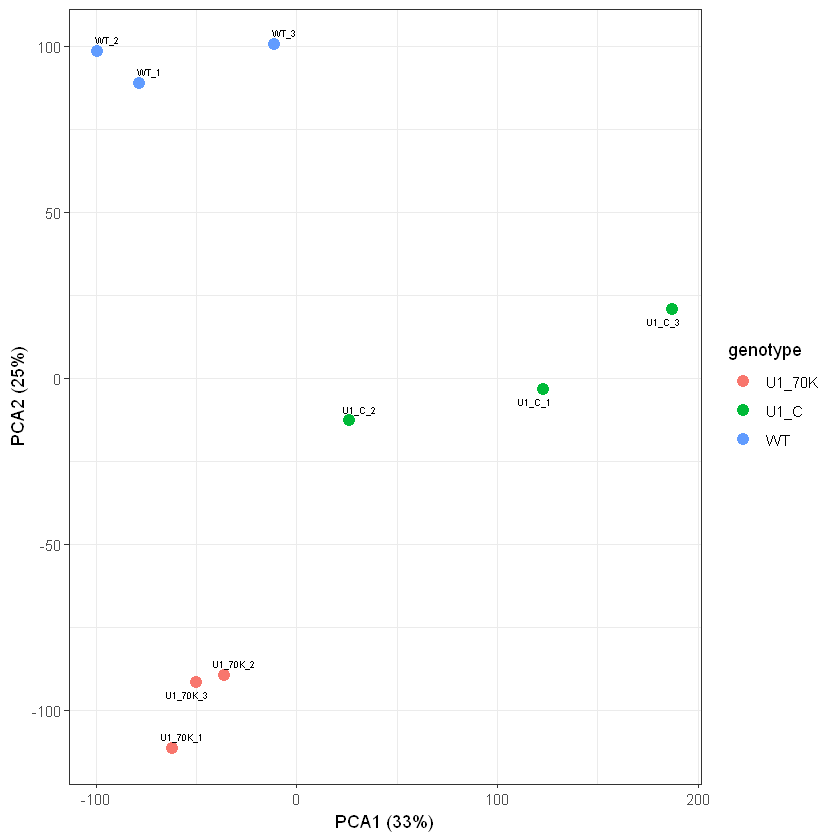

In [5]:
#PCA for PC1 and PC2

pca1 <- ggplot(data=scores,aes(x = PC1, y = PC2, color = genotype)) +
  geom_point(size=3) +
  theme_bw() +
  geom_text_repel(aes(label=label),size=2,color="black")+
  labs(x = paste0("PCA1 (",round(summary$importance[2,1]*100),"%)"),
       y = paste0("PCA2 (",round(summary$importance[2,2]*100),"%)")) 

pca1

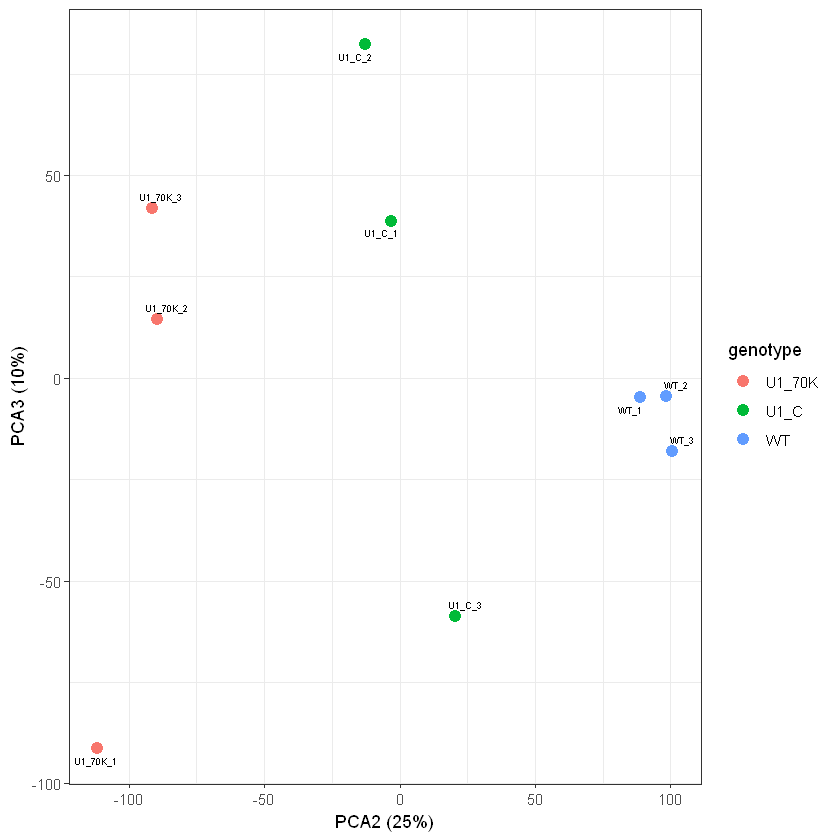

In [6]:
#PCA for PC2 and PC3

pca2 <- ggplot(data=scores,aes(x = PC2, y = PC3, color = genotype)) +
  geom_point(size=3) +
  theme_bw() +
  geom_text_repel(aes(label=label),size=2,color="black") +
  labs(x = paste0("PCA2 (",round(summary$importance[2,2]*100),"%)"),
       y = paste0("PCA3 (",round(summary$importance[2,3]*100),"%)")) 

pca2

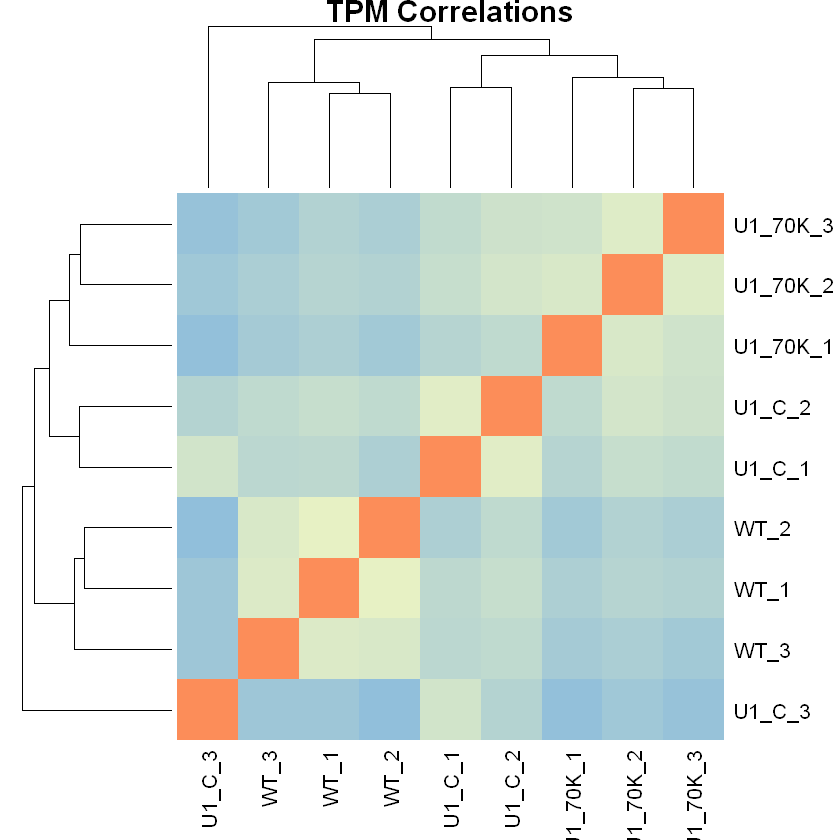

In [7]:
df              = txi$abundance
cor_matrix      = cor(df, method = "spearman")
dend            = as.dendrogram(hclust(dist(cor_matrix)))

corr_heatmap    = heatmap(cor_matrix, Rowv = dend, Colv = dend, col = colorRampPalette(c("#91BFDB", "#FFFFBF", "#FC8D59"))(100), scale = "none", main="TPM Correlations")

Based on the the correlation heatmap, we decided to leave out U1_C_rep3.
Next create the DESeq object using imported quantification, samplesheet and the list that connects transcript and gene (https://ics.hutton.ac.uk/atRTD/RTD3/AtRTD3_gene_transcript.csv)

In [ ]:
dds             = DESeqDataSetFromTximport(txi, samples, design = ~condition)
dds$condition   = factor(dds$condition, levels = c("WT","U1_C", "U1_70K"))
dds$condition   = relevel(dds$condition, ref = "WT")
dds             = dds[,-6]

Now filter all genes, that have 10 or less counts over all samples and perform deseq analysis

In [ ]:
keep    = rowSums(counts(dds)) >= 10
dds     = dds[keep,]
dds     = DESeq(dds)

Check the Dispersion Estimate to judge the quality

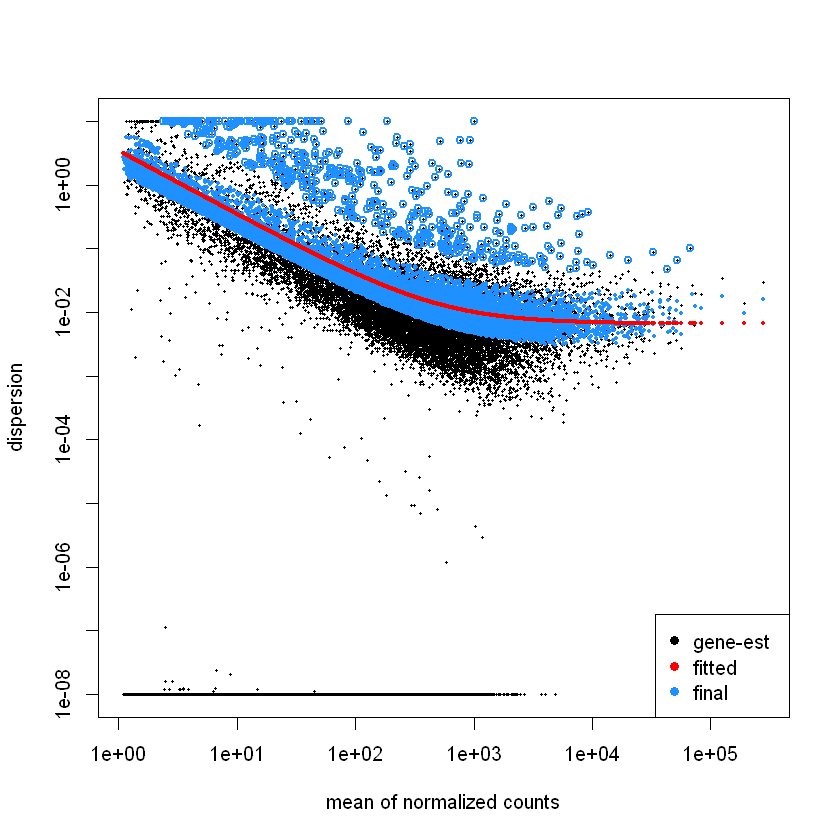

In [10]:
plotDispEsts(dds)

Extract results, check for overlaps and write the lists to csv

In [11]:
res_u1c         = results(dds, name = "condition_U1_C_vs_WT")
res_u170k       = results(dds, name = "condition_U1_70K_vs_WT")

#first single genotypes

up_u1c          = res_u1c   %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange > 0)
up_u170k        = res_u170k %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange > 0)
overlap_up      = intersect(rownames(up_u1c), rownames(up_u170k))

down_u1c        = res_u1c   %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange < 0)
down_u170k      = res_u170k %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange < 0)
overlap_down    = intersect(rownames(down_u1c), rownames(down_u170k))

In [12]:
print(paste("upregulated in amiR-u1c:",     length(rownames(up_u1c))))
print(paste("upregulated in amiR-u170k:",   length(rownames(up_u170k))))
print(paste("overlap upregulated in:", length(overlap_up)))


print(paste("downregulated in amiR-u1c:",     length(rownames(down_u1c))))
print(paste("downregulated in amiR-u170k:",   length(rownames(down_u170k))))
print(paste("overlap downregulated in:",      length(overlap_down)))

[1] "upregulated in amiR-u1c: 2184"
[1] "upregulated in amiR-u170k: 2712"
[1] "overlap upregulated in: 1232"
[1] "downregulated in amiR-u1c: 2060"
[1] "downregulated in amiR-u170k: 2664"
[1] "overlap downregulated in: 1116"


In [13]:
write.csv(overlap_up,    file = "overlap_upregulated_u170k_u1c.csv")
write.csv(overlap_down,  file = "overlap_downregulated_u170k_u1c.csv")

In [14]:
#now write overlap

merged_up       = up_u1c %>% select(baseMean)
merged_up       = transform(merge(merged_up, up_u170k[,-1], by = 0), row.names = Row.names, Row.names=NULL)
merged_up       = transform(merge(merged_up, up_u1c[,-1],   by = 0, suffixes = c("_amiR-u1-70k", "_amirR-u1-c")), row.names = Row.names, Row.names=NULL)

merged_down     = down_u1c %>% select(baseMean)
merged_down     = transform(merge(merged_down, down_u170k[,-1], by = 0), row.names = Row.names, Row.names=NULL)
merged_down     = transform(merge(merged_down, down_u1c[,-1],   by = 0, suffixes = c("_amiR-u1-70k", "_amirR-u1-c")), row.names = Row.names, Row.names=NULL)


In [15]:
write.csv(as.data.frame(res_u170k), file = "results_u170k_vs_wt.csv")
write.csv(as.data.frame(res_u1c),   file = "results_u1c_vs_wt.csv")

# 2. The rmats/splicing analysis

load all files

In [16]:
#first read in all tables
u1c_se      = read.table("results/rmats/U1C/WT_vs_U1C/SE.MATS.JC.txt",          header = T)
u1c_ri      = read.table("results/rmats/U1C/WT_vs_U1C/RI.MATS.JC.txt",          header = T)
u1c_a5s     = read.table("results/rmats/U1C/WT_vs_U1C/A5SS.MATS.JC.txt",        header = T)
u1c_a3s     = read.table("results/rmats/U1C/WT_vs_U1C/A3SS.MATS.JC.txt",        header = T)
u1c_mxe     = read.table("results/rmats/U1C/WT_vs_U1C/MXE.MATS.JC.txt",         header = T)



u170k_se    = read.table("results/rmats/U170K/WT_vs_U170K/SE.MATS.JC.txt",      header = T)
u170k_ri    = read.table("results/rmats/U170K/WT_vs_U170K/RI.MATS.JC.txt",      header = T)
u170k_a5s   = read.table("results/rmats/U170K/WT_vs_U170K/A5SS.MATS.JC.txt",    header = T)
u170k_a3s   = read.table("results/rmats/U170K/WT_vs_U170K/A3SS.MATS.JC.txt",    header = T)
u170k_mxe   = read.table("results/rmats/U170K/WT_vs_U170K/MXE.MATS.JC.txt",     header = T)

In [17]:
#define criteria to find same events and find overlaps between groups

overlap_se = merge(u1c_se %>% filter(FDR < 0.05) %>% 
      select(GeneID, exonStart_0base, exonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_se %>% filter(FDR < 0.05) %>% select(GeneID, exonStart_0base, exonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_ri = merge(u1c_ri %>% filter(FDR < 0.05) %>% 
      select(GeneID, riExonStart_0base , riExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_ri %>% filter(FDR < 0.05) %>% select(GeneID, riExonStart_0base, riExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_a5s = merge(u1c_a5s %>% filter(FDR < 0.05) %>% 
      select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      u170k_a5s %>% filter(FDR < 0.05) %>% select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_a3s = merge(u1c_a3s %>% filter(FDR < 0.05) %>%
      select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE ,FDR, IncLevelDifference),
      u170k_a3s %>% filter(FDR < 0.05) %>% select(GeneID, longExonStart_0base, longExonEnd, shortES, shortEE, flankingES, flankingEE,FDR, IncLevelDifference),
      by = c(1:7), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

overlap_mxe = merge(u1c_mxe %>% filter(FDR < 0.05) %>%
      select(GeneID, X1stExonStart_0base, X1stExonEnd, X2ndExonStart_0base, X2ndExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      u170k_mxe %>% filter(FDR < 0.05) %>% select(GeneID, X1stExonStart_0base, X1stExonEnd, X2ndExonStart_0base, X2ndExonEnd, upstreamES, upstreamEE, downstreamES, downstreamEE,FDR, IncLevelDifference),
      by = c(1:9), suffixes = c("_amiR-u1-c", "_amirR-u1-70k"))

In [18]:
#get just the numbers
numbers_u1c     = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), amount = c(1:5),     amount_up = c(1:5),     amount_down = c(1:5))
numbers_u170k   = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), amount = c(1:5),     amount_up = c(1:5),     amount_down = c(1:5))
numbers_overlap = data.frame(event = c("A3SS", "A5SS", "MXE", "RI", "SE"), overlap = c(1:5),    overlap_up = c(1:5),    overlap_down = c(1:5), ambi = c(1:5))

In [19]:
#filter by enhanced and repressed
numbers_u170k[1,2] = u170k_a3s  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[1,3] = u170k_a3s  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[1,4] = u170k_a3s  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[2,2] = u170k_a5s  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[2,3] = u170k_a5s  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[2,4] = u170k_a5s  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[3,2] = u170k_mxe  %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[3,3] = u170k_mxe  %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[3,4] = u170k_mxe  %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[4,2] = u170k_ri   %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[4,3] = u170k_ri   %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[4,4] = u170k_ri   %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u170k[5,2] = u170k_se   %>% filter(FDR < 0.05) %>% nrow
numbers_u170k[5,3] = u170k_se   %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u170k[5,4] = u170k_se   %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow





numbers_u1c[1,2] = u1c_a3s      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[1,3] = u1c_a3s      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[1,4] = u1c_a3s      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[2,2] = u1c_a5s      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[2,3] = u1c_a5s      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[2,4] = u1c_a5s      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[3,2] = u1c_mxe      %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[3,3] = u1c_mxe      %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[3,4] = u1c_mxe      %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[4,2] = u1c_ri       %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[4,3] = u1c_ri       %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[4,4] = u1c_ri       %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow

numbers_u1c[5,2] = u1c_se       %>% filter(FDR < 0.05) %>% nrow
numbers_u1c[5,3] = u1c_se       %>% filter(FDR < 0.05 & IncLevelDifference > 0) %>% nrow
numbers_u1c[5,4] = u1c_se       %>% filter(FDR < 0.05 & IncLevelDifference < 0) %>% nrow


In [20]:
#get overlap numbers
numbers_overlap[1,2] = overlap_a3s %>% nrow
numbers_overlap[1,3] = overlap_a3s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` > 0) %>% nrow
numbers_overlap[1,4] = overlap_a3s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` < 0 & `IncLevelDifference_amirR-u1-70k` < 0) %>% nrow
numbers_overlap[1,5] = overlap_a3s %>% filter((`IncLevelDifference_amiR-u1-c`< 0 & `IncLevelDifference_amirR-u1-70k`> 0) | (`IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` < 0)) %>% nrow

numbers_overlap[2,2] = overlap_a5s %>% nrow
numbers_overlap[2,3] = overlap_a5s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` > 0) %>% nrow
numbers_overlap[2,4] = overlap_a5s %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` < 0 & `IncLevelDifference_amirR-u1-70k` < 0) %>% nrow
numbers_overlap[2,5] = overlap_a5s %>% filter((`IncLevelDifference_amiR-u1-c`< 0 & `IncLevelDifference_amirR-u1-70k`> 0) | (`IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` < 0)) %>% nrow

numbers_overlap[3,2] = overlap_mxe %>% nrow
numbers_overlap[3,3] = overlap_mxe %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` > 0) %>% nrow
numbers_overlap[3,4] = overlap_mxe %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` < 0 & `IncLevelDifference_amirR-u1-70k` < 0) %>% nrow
numbers_overlap[3,5] = overlap_mxe %>% filter((`IncLevelDifference_amiR-u1-c`< 0 & `IncLevelDifference_amirR-u1-70k`> 0) | (`IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` < 0)) %>% nrow

numbers_overlap[4,2] = overlap_ri %>% nrow
numbers_overlap[4,3] = overlap_ri %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` > 0) %>% nrow
numbers_overlap[4,4] = overlap_ri %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` < 0 & `IncLevelDifference_amirR-u1-70k` < 0) %>% nrow
numbers_overlap[4,5] = overlap_ri %>% filter((`IncLevelDifference_amiR-u1-c`< 0 & `IncLevelDifference_amirR-u1-70k`> 0) | (`IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` < 0)) %>% nrow

numbers_overlap[5,2] = overlap_se %>% nrow
numbers_overlap[5,3] = overlap_se %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` > 0) %>% nrow
numbers_overlap[5,4] = overlap_se %>% filter(`FDR_amiR-u1-c` < 0.05 & `FDR_amirR-u1-70k` < 0.05 & `IncLevelDifference_amiR-u1-c` < 0 & `IncLevelDifference_amirR-u1-70k` < 0) %>% nrow
numbers_overlap[5,5] = overlap_se %>% filter((`IncLevelDifference_amiR-u1-c`< 0 & `IncLevelDifference_amirR-u1-70k`> 0) | (`IncLevelDifference_amiR-u1-c` > 0 & `IncLevelDifference_amirR-u1-70k` < 0)) %>% nrow


In [21]:
summary = merge(merge(numbers_u1c, numbers_u170k, by = "event", suffixes = c("_u1c", "_u170k")), numbers_overlap, by = 1)

In [22]:
summary

event,amount_u1c,amount_up_u1c,amount_down_u1c,amount_u170k,amount_up_u170k,amount_down_u170k,overlap,overlap_up,overlap_down,ambi
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A3SS,774,561,213,995,675,320,305,218,86,1
A5SS,1047,679,368,1071,632,439,432,273,158,1
MXE,91,41,50,119,52,67,20,11,9,0
RI,3136,1585,1551,4175,1970,2205,1313,574,737,2
SE,1271,1172,99,1361,1220,141,741,685,56,0


In [23]:
#write output data
write.csv(overlap_a3s,  "overlap_A3SS.csv")
write.csv(overlap_a5s,  "overlap_A5SS.csv")
write.csv(overlap_mxe,  "overlap_MXE.csv")
write.csv(overlap_ri,   "overlap_RI.csv")
write.csv(overlap_se,   "overlap_SE.csv")
write.csv(summary, "summary.csv")

## 2.1 get venn diagrams and p_value of overlap.

In [ ]:
suppressMessages(library("VennDiagram"))

In [25]:
universe_a3s_up = unique(c(u1c_a3s %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_a3s %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname()))
universe_a3s_down = unique(c(u1c_a3s %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_a3s %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname()))

universe_a5s_up = unique(c(u1c_a5s %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_a5s %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname()))
universe_a5s_down = unique(c(u1c_a5s %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_a5s %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname()))

universe_mxe_up = unique(c(u1c_mxe %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_mxe %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname()))
universe_mxe_down = unique(c(u1c_mxe %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_mxe %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname()))

universe_ri_up = unique(c(u1c_ri %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_ri %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname()))
universe_ri_down = unique(c(u1c_ri %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_ri %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname()))

universe_se_up = unique(c(u1c_a3s %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_se %>% filter(IncLevelDifference > 0) %>% select("GeneID") %>% unlist() %>% unname()))
universe_se_down = unique(c(u1c_a3s %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname(), u170k_se %>% filter(IncLevelDifference < 0) %>% select("GeneID") %>% unlist() %>% unname()))



In [26]:
svg("Venn_a3ss_up.svg")
draw.pairwise.venn(summary[1,3], summary[1,6], summary[1,9], category = c("A3SS up amiR-u1c", "A3SS up amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[1,9]-1,  summary[1,3], length(universe_a3s_up),  summary[1,6],  lower.tail = F) 
paste0("The probability that the overlap (",summary[1,9], ") between all A3SS up in amiR-u1c (",summary[1,3],") and all A3SS up in amiR-u170k (",summary[1,6],"), where the universe is (",length(universe_a3s_up),") is happening by chance is ",f )


(polygon[GRID.polygon.165], polygon[GRID.polygon.166], polygon[GRID.polygon.167], polygon[GRID.polygon.168], text[GRID.text.169], text[GRID.text.170], text[GRID.text.171], text[GRID.text.172], text[GRID.text.173]) 

png 
  2

[1] "The probability that the overlap (218) between all A3SS up in amiR-u1c (561) and all A3SS up in amiR-u170k (675), where the universe is (8703) is happening by chance is 2.77143729187026e-111"

In [27]:
svg("Venn_a5ss_up.svg")
draw.pairwise.venn(summary[2,3], summary[2,6], summary[2,9], category = c("A5SS up amiR-u1c", "A5SS up amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[2,9]-1,  summary[2,3], length(universe_a5s_up),  summary[2,6],  lower.tail = F) 
paste0("The probability that the overlap (",summary[2,9], ") between all A5SS up in amiR-u1c (",summary[2,3],") and all A5SS up in amiR-u170k (",summary[2,6],"), where the universe is (",length(universe_a5s_up),") is happening by chance is ",f )


(polygon[GRID.polygon.174], polygon[GRID.polygon.175], polygon[GRID.polygon.176], polygon[GRID.polygon.177], text[GRID.text.178], text[GRID.text.179], text[GRID.text.180], text[GRID.text.181], text[GRID.text.182]) 

png 
  2

[1] "The probability that the overlap (273) between all A5SS up in amiR-u1c (679) and all A5SS up in amiR-u170k (632), where the universe is (7303) is happening by chance is 4.93092406389252e-141"

In [28]:
svg("Venn_mxe_up.svg")
draw.pairwise.venn(summary[3,3], summary[3,6], summary[3,9], category = c("MXE up amiR-u1c", "MXE up amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[3,9]-1,  summary[3,3], length(universe_mxe_up),  summary[3,6],  lower.tail = F) 
paste0("The probability that the overlap (",summary[3,9], ") between all MXE up in amiR-u1c (",summary[3,3],") and all MXE up in amiR-u170k (",summary[3,6],"), where the universe is (",length(universe_mxe_up),") is happening by chance is ",f )


(polygon[GRID.polygon.183], polygon[GRID.polygon.184], polygon[GRID.polygon.185], polygon[GRID.polygon.186], text[GRID.text.187], text[GRID.text.188], text[GRID.text.189], text[GRID.text.190], text[GRID.text.191]) 

png 
  2

[1] "The probability that the overlap (11) between all MXE up in amiR-u1c (41) and all MXE up in amiR-u170k (52), where the universe is (341) is happening by chance is 0.013120490873172"

In [29]:
svg("Venn_ri_up.svg")
draw.pairwise.venn(summary[4,3], summary[4,6], summary[4,9], category = c("RI up amiR-u1c", "RI up amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[4,9]-1,  summary[4,3], length(universe_ri_up),  summary[4,6],  lower.tail = F) 
paste0("The probability that the overlap (",summary[4,9], ") between all RI up in amiR-u1c (",summary[4,3],") and all RI up in amiR-u170k (",summary[4,6],"), where the universe is (",length(universe_ri_up),") is happening by chance is ",f )


(polygon[GRID.polygon.192], polygon[GRID.polygon.193], polygon[GRID.polygon.194], polygon[GRID.polygon.195], text[GRID.text.196], text[GRID.text.197], text[GRID.text.198], text[GRID.text.199], text[GRID.text.200]) 

png 
  2

[1] "The probability that the overlap (574) between all RI up in amiR-u1c (1585) and all RI up in amiR-u170k (1970), where the universe is (11695) is happening by chance is 1.11823852420838e-115"

In [30]:
svg("Venn_se_up.svg")
draw.pairwise.venn(summary[5,3], summary[5,6], summary[5,9], category = c("SE up amiR-u1c", "SE up amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[5,9]-1,  summary[5,3], length(universe_se_up),  summary[5,6],  lower.tail = F) 
paste0("The probability that the overlap (",summary[5,9], ") between all SE up in amiR-u1c (",summary[5,3],") and all SE up in amiR-u170k (",summary[5,6],"), where the universe is (",length(universe_se_up),") is happening by chance is ",f )


(polygon[GRID.polygon.201], polygon[GRID.polygon.202], polygon[GRID.polygon.203], polygon[GRID.polygon.204], text[GRID.text.205], text[GRID.text.206], text[GRID.text.207], text[GRID.text.208], text[GRID.text.209]) 

png 
  2

[1] "The probability that the overlap (685) between all SE up in amiR-u1c (1172) and all SE up in amiR-u170k (1220), where the universe is (7828) is happening by chance is 0"

In [31]:
svg("Venn_a3ss_down.svg")
draw.pairwise.venn(summary[1,4], summary[1,7], summary[1,10], category = c("A3SS down amiR-u1c", "A3SS down amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[1,10]-1,  summary[1,4], length(universe_a3s_down),  summary[1,7],  lower.tail = F) 
paste0("The probability that the overlap (",summary[1,10], ") between all A3SS up in amiR-u1c (",summary[1,4],") and all A3SS up in amiR-u170k (",summary[1,7],"), where the universe is (",length(universe_a3s_down),") is happening by chance is ",f )


(polygon[GRID.polygon.210], polygon[GRID.polygon.211], polygon[GRID.polygon.212], polygon[GRID.polygon.213], text[GRID.text.214], text[GRID.text.215], text[GRID.text.216], text[GRID.text.217], text[GRID.text.218]) 

png 
  2

[1] "The probability that the overlap (86) between all A3SS up in amiR-u1c (213) and all A3SS up in amiR-u170k (320), where the universe is (7700) is happening by chance is 2.43652862609796e-66"

In [32]:
svg("Venn_a5ss_down.svg")
draw.pairwise.venn(summary[2,4], summary[2,7], summary[2,10], category = c("A5SS down amiR-u1c", "A5SS down amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[2,10]-1,  summary[2,4], length(universe_a5s_down),  summary[2,7],  lower.tail = F) 
paste0("The probability that the overlap (",summary[2,10], ") between all A5SS up in amiR-u1c (",summary[2,4],") and all A5SS up in amiR-u170k (",summary[2,7],"), where the universe is (",length(universe_a5s_down),") is happening by chance is ",f )


(polygon[GRID.polygon.219], polygon[GRID.polygon.220], polygon[GRID.polygon.221], polygon[GRID.polygon.222], text[GRID.text.223], text[GRID.text.224], text[GRID.text.225], text[GRID.text.226], text[GRID.text.227]) 

png 
  2

[1] "The probability that the overlap (158) between all A5SS up in amiR-u1c (368) and all A5SS up in amiR-u170k (439), where the universe is (6209) is happening by chance is 4.87759524160077e-96"

In [33]:
svg("Venn_mxe_down.svg")
draw.pairwise.venn(summary[3,4], summary[3,7], summary[3,10], category = c("MXE down amiR-u1c", "MXE down amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[3,10]-1,  summary[3,4], length(universe_mxe_up),  summary[3,7],  lower.tail = F) 
paste0("The probability that the overlap (",summary[3,10], ") between all MXE down in amiR-u1c (",summary[3,4],") and all MXE down in amiR-u170k (",summary[3,7],"), where the universe is (",length(universe_mxe_down),") is happening by chance is ",f )


(polygon[GRID.polygon.228], polygon[GRID.polygon.229], polygon[GRID.polygon.230], polygon[GRID.polygon.231], text[GRID.text.232], text[GRID.text.233], text[GRID.text.234], text[GRID.text.235], text[GRID.text.236]) 

png 
  2

[1] "The probability that the overlap (9) between all MXE down in amiR-u1c (50) and all MXE down in amiR-u170k (67), where the universe is (372) is happening by chance is 0.497539613113088"

In [34]:
svg("Venn_ri_down.svg")
draw.pairwise.venn(summary[4,4], summary[4,7], summary[4,10], category = c("RI down amiR-u1c", "RI down amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[4,10]-1,  summary[4,4], length(universe_ri_down),  summary[4,7],  lower.tail = F) 
paste0("The probability that the overlap (",summary[4,10], ") between all RI down in amiR-u1c (",summary[4,4],") and all RI down in amiR-u170k (",summary[4,7],"), where the universe is (",length(universe_ri_down),") is happening by chance is ",f )


(polygon[GRID.polygon.237], polygon[GRID.polygon.238], polygon[GRID.polygon.239], polygon[GRID.polygon.240], text[GRID.text.241], text[GRID.text.242], text[GRID.text.243], text[GRID.text.244], text[GRID.text.245]) 

png 
  2

[1] "The probability that the overlap (737) between all RI down in amiR-u1c (1551) and all RI down in amiR-u170k (2205), where the universe is (11251) is happening by chance is 4.45207509083954e-198"

In [35]:
svg("Venn_se_down.svg")
draw.pairwise.venn(summary[5,4], summary[5,7], summary[5,10], category = c("SE down amiR-u1c", "SE down amirR-u170k"), fill = c('#68A8DB', '#71AD45'), col = c(NA, NA))
dev.off()

f = phyper(summary[5,10]-1,  summary[5,4], length(universe_se_down),  summary[5,7],  lower.tail = F) 
paste0("The probability that the overlap (",summary[5,10], ") between all SE down in amiR-u1c (",summary[5,4],") and all SE down in amiR-u170k (",summary[5,7],"), where the universe is (",length(universe_se_down),") is happening by chance is ",f )


(polygon[GRID.polygon.246], polygon[GRID.polygon.247], polygon[GRID.polygon.248], polygon[GRID.polygon.249], text[GRID.text.250], text[GRID.text.251], text[GRID.text.252], text[GRID.text.253], text[GRID.text.254]) 

png 
  2

[1] "The probability that the overlap (56) between all SE down in amiR-u1c (99) and all SE down in amiR-u170k (141), where the universe is (6660) is happening by chance is 3.60158858866212e-72"

In [36]:
reshape_event <- function(event, amounts) {

  amounts <- as.numeric(amounts)
  names(amounts) <- names(summary)[-1]  
  up_data <- data.frame(
    event = event,
    seite = "up",
    label = c("amiR-u1c", "amiR-u170k", "overlap_pos", "overlap_neg"),
    original = c(amounts["amount_up_u1c"], amounts["amount_up_u170k"], amounts["overlap_up"], amounts["overlap_up"]),
    forplotting = c(amounts["amount_up_u1c"] - amounts["overlap_up"] , (-1)*(amounts["amount_up_u170k"] - amounts["overlap_up"]), amounts["overlap_up"] / 2, -amounts["overlap_up"] / 2)
  )


  down_data <- data.frame(
    event = event,
    seite = "down",
    label = c("amiR-u1c", "amiR-u170k", "overlap_pos", "overlap_neg"),
    original = c(amounts["amount_down_u1c"], amounts["amount_down_u170k"], amounts["overlap_down"], amounts["overlap_down"]),
    forplotting = c(amounts["amount_down_u1c"] - amounts["overlap_down"], (-1)*(amounts["amount_down_u170k"] - amounts["overlap_down"]), amounts["overlap_down"] / 2, -amounts["overlap_down"] / 2)
  )
  
return(bind_rows(up_data, down_data))
}


In [ ]:
suppressWarnings((transformed_df <- bind_rows(apply(summary, 1, function(row) reshape_event(row["event"], row[-1])))))

png 
  2

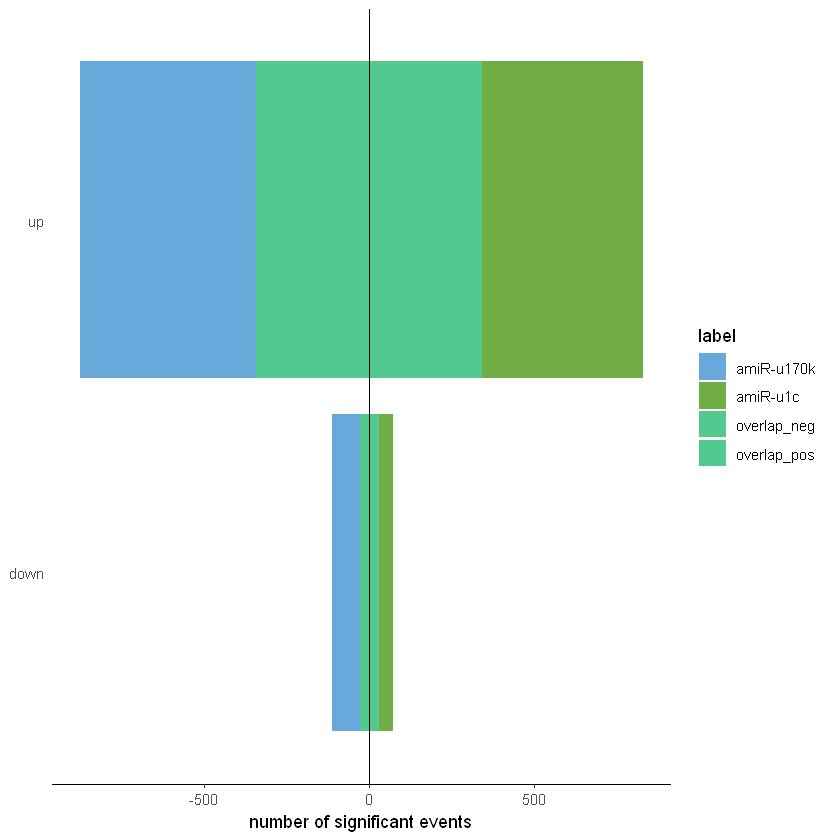

In [38]:
svg("SE_new.svg")
a=ggplot(transformed_df %>% filter(event == "SE"), aes(x = seite, y = forplotting, fill = label)) +
 geom_bar(stat = "identity" ) +
 geom_hline(yintercept = 0) +
 scale_fill_manual(values = c( "#68A8DB", "#71AD45", "#52c98e","#52c98e")) +
 coord_flip() +
 theme_classic() +
 theme(axis.line.y=element_blank(),
          axis.ticks.y=element_blank(),
          axis.title.y=element_blank()) +
 ylab( "number of significant events") 
 
dev.off()
a

png 
  2

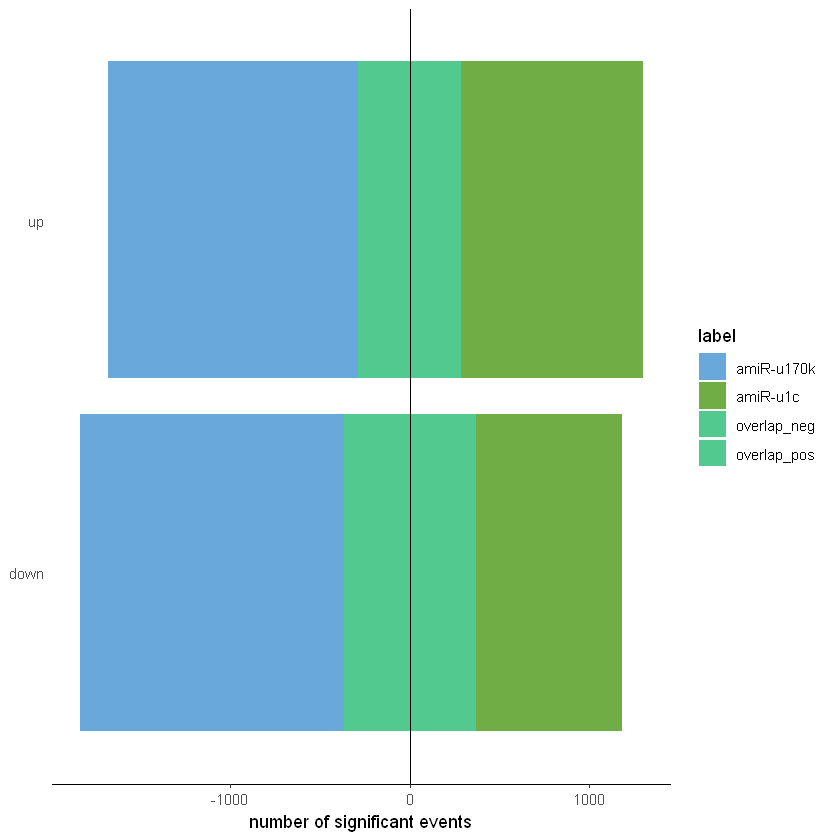

In [39]:
svg("RI_new.svg")
a=ggplot(transformed_df %>% filter(event == "RI"), aes(x = seite, y = forplotting, fill = label)) +
 geom_bar(stat = "identity" ) +
 geom_hline(yintercept = 0) +
 scale_fill_manual(values = c( "#68A8DB", "#71AD45", "#52c98e","#52c98e")) +
 coord_flip() +
 theme_classic() +
 theme(axis.line.y=element_blank(),
          axis.ticks.y=element_blank(),
          axis.title.y=element_blank()) +
 ylab( "number of significant events")
dev.off()
a

png 
  2

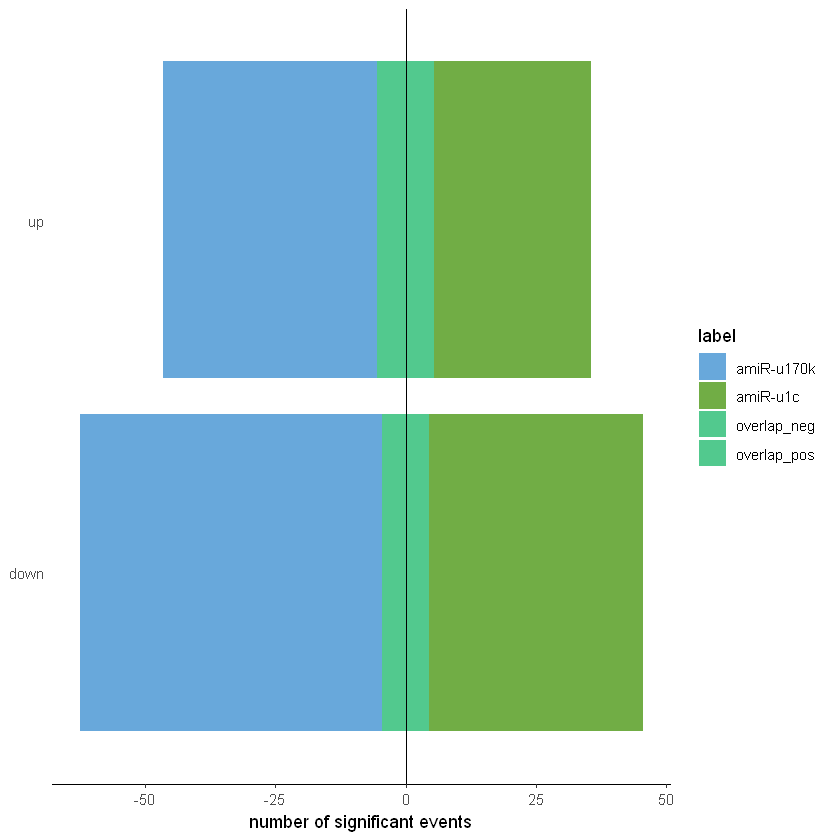

In [40]:
svg("MXE_new.svg")
a=ggplot(transformed_df %>% filter(event == "MXE"), aes(x = seite, y = forplotting, fill = label)) +
 geom_bar(stat = "identity" ) +
 geom_hline(yintercept = 0) +
 scale_fill_manual(values = c( "#68A8DB", "#71AD45", "#52c98e","#52c98e")) +
 coord_flip() +
 theme_classic() +
 theme(axis.line.y=element_blank(),
          axis.ticks.y=element_blank(),
          axis.title.y=element_blank()) +
 ylab( "number of significant events")
dev.off()
a

png 
  2

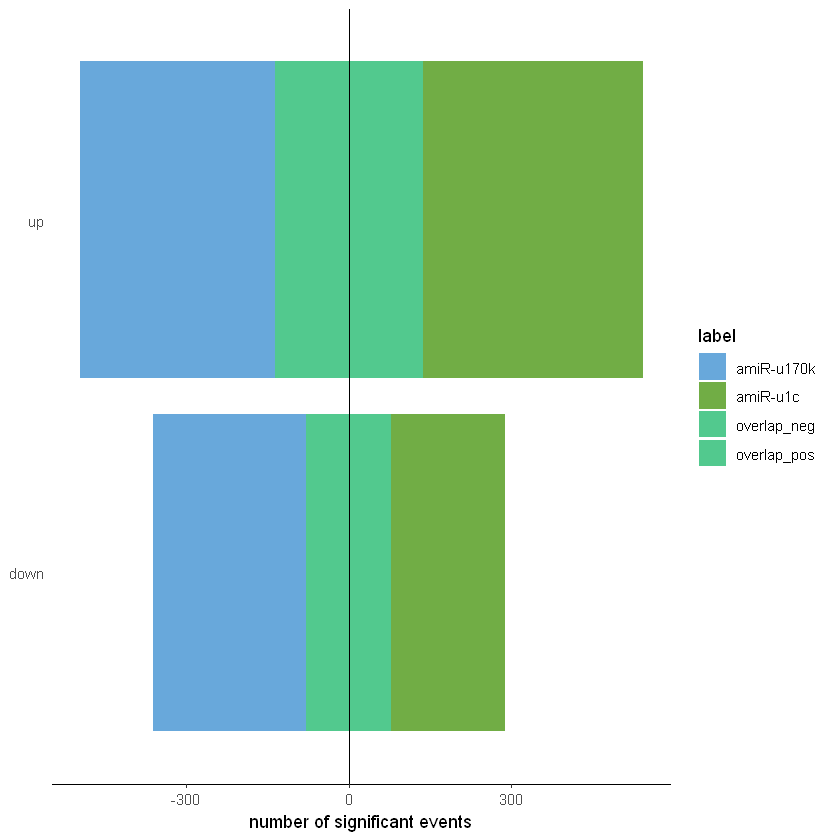

In [41]:
svg("A5SS_new.svg")
a = ggplot(transformed_df %>% filter(event == "A5SS"), aes(x = seite, y = forplotting, fill = label)) +
 geom_bar(stat = "identity" ) +
 geom_hline(yintercept = 0) +
 scale_fill_manual(values = c( "#68A8DB", "#71AD45", "#52c98e","#52c98e")) +
 coord_flip() +
 theme_classic() +
 theme(axis.line.y=element_blank(),
          axis.ticks.y=element_blank(),
          axis.title.y=element_blank()) +
 ylab( "number of significant events")
dev.off()
a

png 
  2

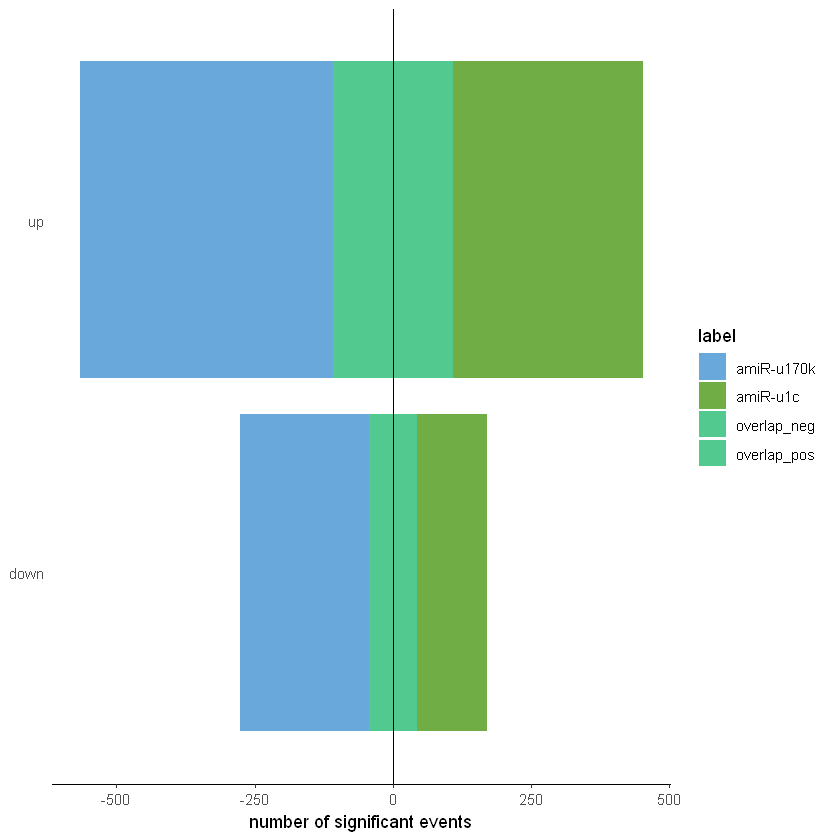

In [42]:
svg("A3SS_new.svg")
a = ggplot(transformed_df %>% filter(event == "A3SS"), aes(x = seite, y = forplotting, fill = label)) +
 geom_bar(stat = "identity" ) +
 geom_hline(yintercept = 0) +
 scale_fill_manual(values = c( "#68A8DB", "#71AD45", "#52c98e","#52c98e")) +
 coord_flip() +
 theme_classic() +
 theme(axis.line.y=element_blank(),
          axis.ticks.y=element_blank(),
          axis.title.y=element_blank()) +
 ylab( "number of significant events")
dev.off()

a

png 
  2

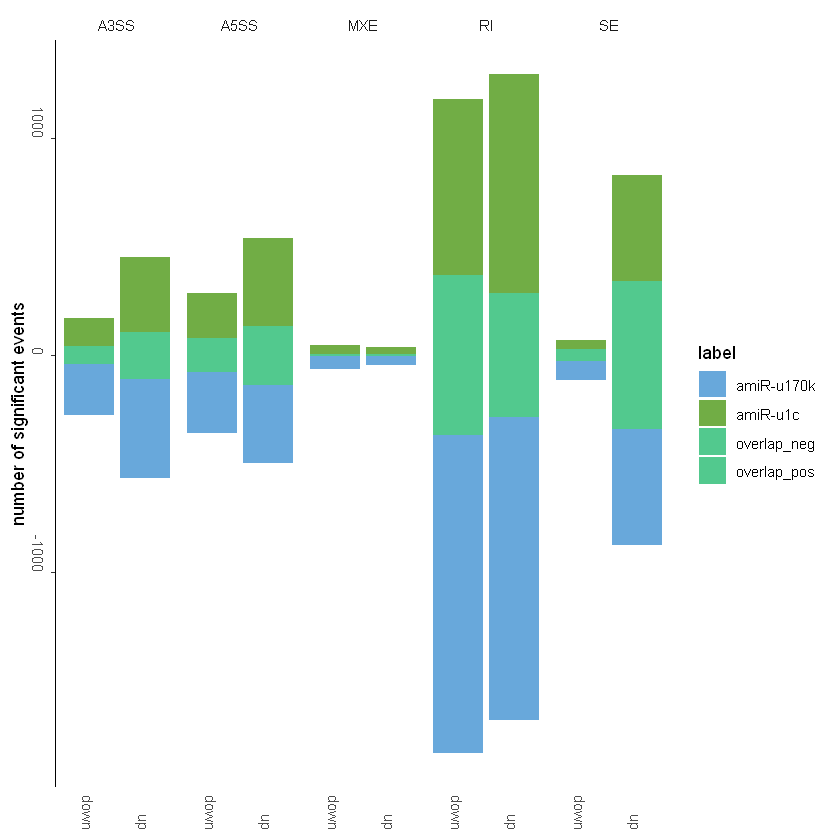

In [43]:
svg("all_events_new.svg")

a = ggplot(transformed_df, aes(x = seite, y = forplotting, fill = label)) +
 geom_bar(stat = "identity") +
 facet_grid(cols = vars(event), switch = 'y') +
 scale_fill_manual(values = c( "#68A8DB", "#71AD45", "#52c98e","#52c98e")) +
 theme_classic() +
 theme(axis.line.x=element_blank(),
          axis.ticks.x=element_blank(),
          axis.title.x=element_blank(), 
          strip.placement = "outside",
          strip.background = element_rect(fill = NA, color = "white"),
          panel.spacing = unit(-.01,"cm"),
          axis.text.x = element_text(angle = -90, vjust = 0.5, hjust = 1),
          axis.text.y = element_text(angle = -90, vjust = 0.5, hjust = 1),
          strip.text.y.left = element_text(angle = 0)) +
 ylab( "number of significant events") 


dev.off()

a

# 3. Analysis for revision

## 3.1 Nucleotide Frequency


In [ ]:
suppressMessages(library("seqTools"))
suppressMessages(library(patchwork))

### 3.1.1 Nucleotide Frequency around **proximal** PA-Sites that are from the composite repressed category in amiR-U170K

In [45]:
fq_distal_pA_comp_rep_u170k = fastqq("results/fastq_for_nucfreq/proximal_pA_comp_rep_u170k.fq")
a = as.data.frame(nucFreq(fq_distal_pA_comp_rep_u170k,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_distal_pA_comp_rep_u170k@nReads


[fastqq] File ( 1/1) 'results/fastq_for_nucfreq/proximal_pA_comp_rep_u170k.fq'	done.


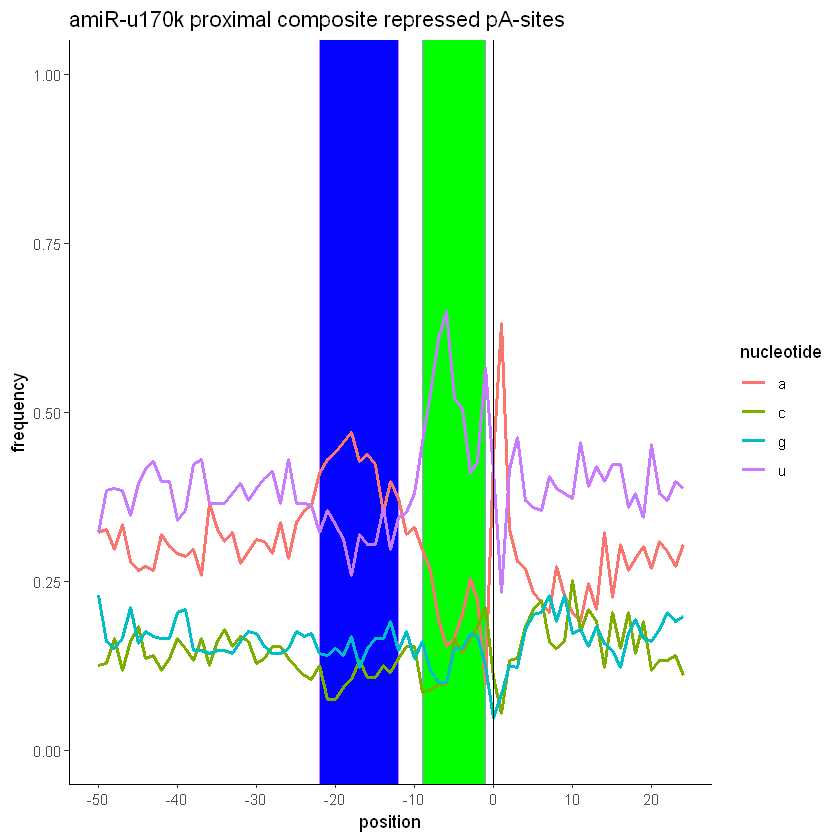

In [46]:
plot_proximal_u170k_comp_rep_pA_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("amiR-u170k proximal composite repressed pA-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_proximal_u170k_comp_rep_pA_light

### 3.1.2 Nucleotide Frequency around **distal** PA-Sites that are from the composite repressed category in amiR-U170K

In [47]:
fq_distal_pA_where_comp_rep_u170k = fastqq("results/fastq_for_nucfreq/distal_pA_where_comp_rep_u170k.fq")
a = as.data.frame(nucFreq(fq_distal_pA_where_comp_rep_u170k,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")

a$frequency = a$frequency/fq_distal_pA_where_comp_rep_u170k@nReads

[fastqq] File ( 1/1) 'results/fastq_for_nucfreq/distal_pA_where_comp_rep_u170k.fq'	done.


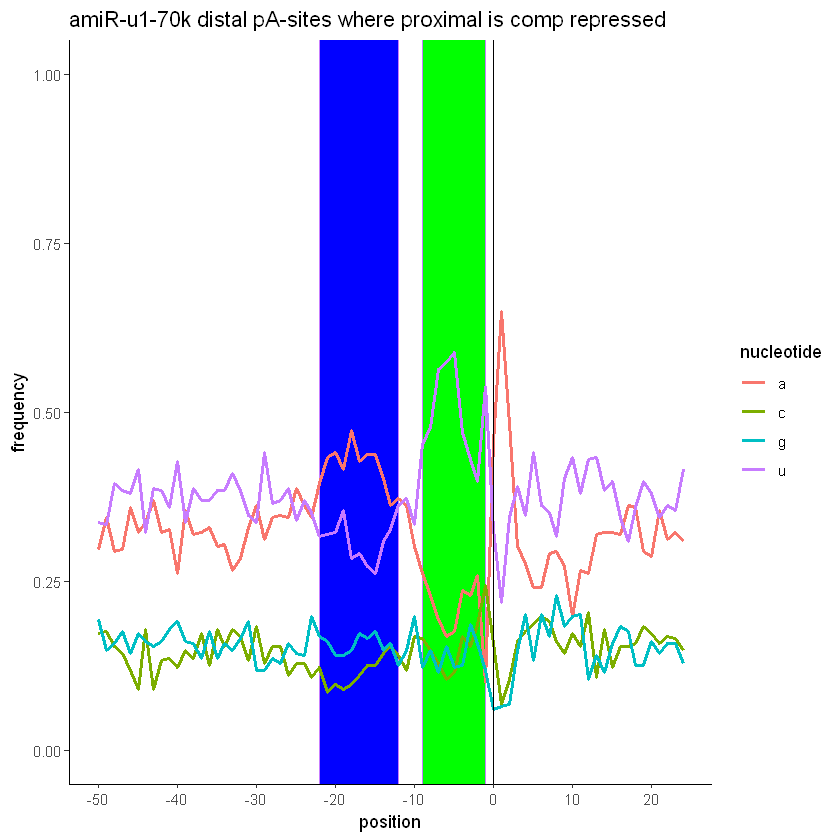

In [48]:
plot_u170k_distal_sites_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) + 
  ggtitle("amiR-u1-70k distal pA-sites where proximal is comp repressed") + 
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.3, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) + 
  ylim(0,1) +
  theme_classic()

plot_u170k_distal_sites_light

### 3.1.3 Nucleotide Frequency around **proximal** PA-Sites that are from the composite repressed category in amiR-U1C

In [49]:
fq_proximal_pA_comp_rep_u1c = fastqq("results/fastq_for_nucfreq/proximal_pA_comp_rep_u1c.fq")
a = as.data.frame(nucFreq(fq_proximal_pA_comp_rep_u1c,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_proximal_pA_comp_rep_u1c@nReads

[fastqq] File ( 1/1) 'results/fastq_for_nucfreq/proximal_pA_comp_rep_u1c.fq'	done.


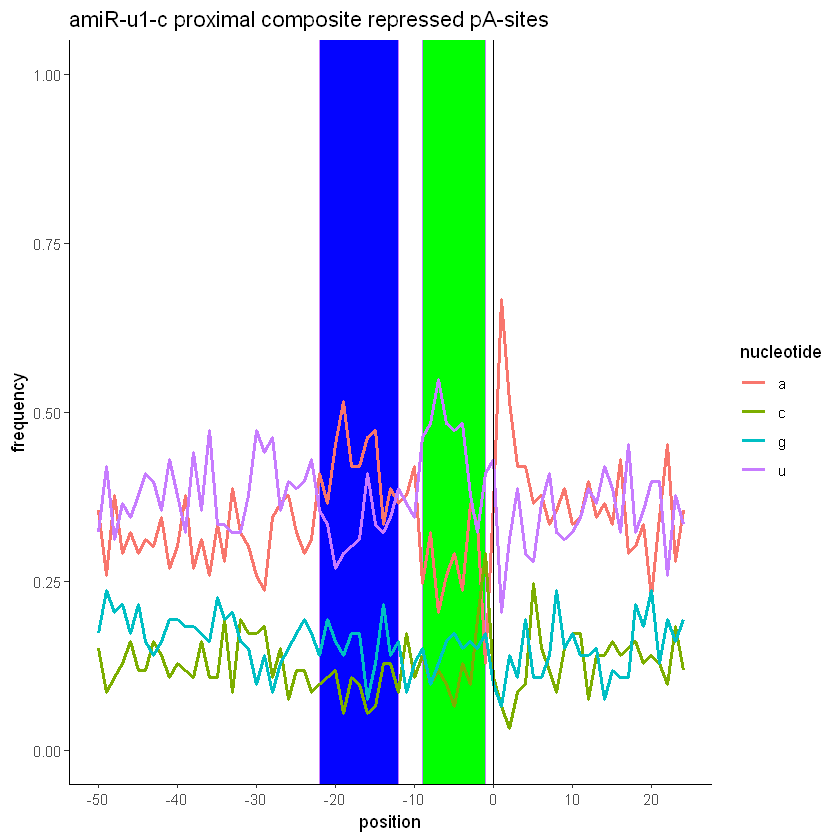

In [50]:
plot_proximal_u1c_comp_rep_pA_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("amiR-u1-c proximal composite repressed pA-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_proximal_u1c_comp_rep_pA_light


### 3.1.4 Nucleotide Frequency around **distal** PA-Sites that are from the composite repressed category in amiR-U1C

In [51]:
fq_distal_u1c_comp_rep_pA_light = fastqq("results/fastq_for_nucfreq/distal_pA_where_comp_rep_u1c.fq")
a = as.data.frame(nucFreq(fq_distal_u1c_comp_rep_pA_light,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_distal_u1c_comp_rep_pA_light@nReads

[fastqq] File ( 1/1) 'results/fastq_for_nucfreq/distal_pA_where_comp_rep_u1c.fq'	done.


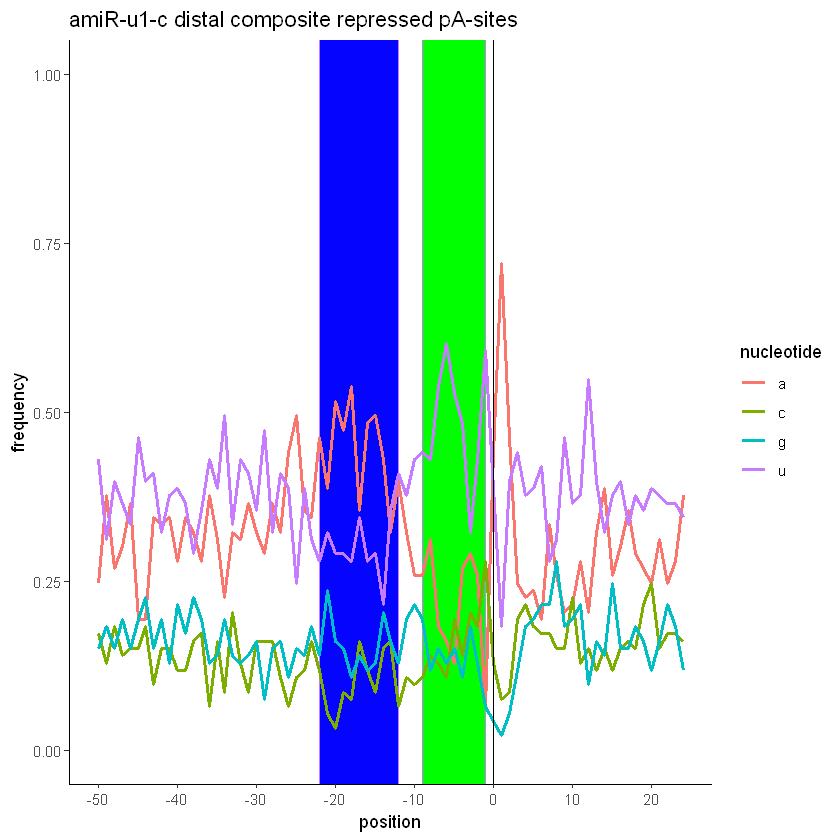

In [52]:
plot_distal_u1c_comp_rep_pA_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("amiR-u1-c distal composite repressed pA-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_distal_u1c_comp_rep_pA_light

### 3.1.5 Nucleotide Frequency around the PA-sites that are normally used by the WT and are unaffected by the knockdown of U1C or U170K


In [53]:
fq_non_affected_WT_PAs = fastqq("results/fastq_for_nucfreq/non_affected_WT_consensus_pA_sites.fq")
a = as.data.frame(nucFreq(fq_non_affected_WT_PAs,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_non_affected_WT_PAs@nReads

[fastqq] File ( 1/1) 'results/fastq_for_nucfreq/non_affected_WT_consensus_pA_sites.fq'	done.


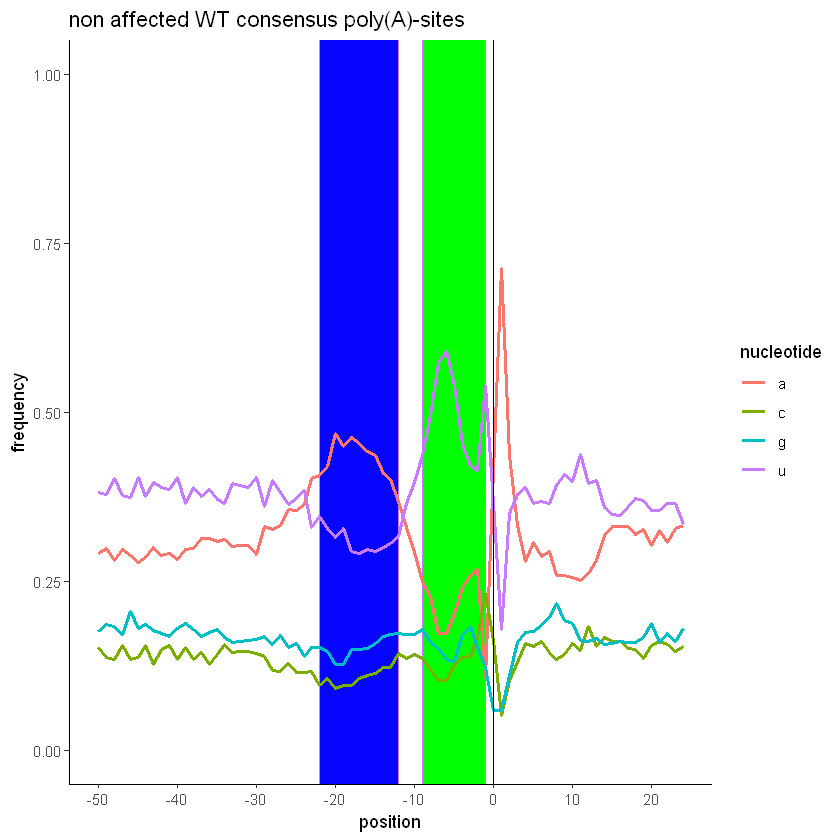

In [54]:
plot_non_affected_WT_PAs_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("non affected WT consensus poly(A)-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_non_affected_WT_PAs_light

### 3.1.6 Nucleotide Frequency around the position that is at 1/3 of the intron length of all introns

In [55]:
fq_onethird_of_all_introns = fastqq("results/fastq_for_nucfreq/bed_position_at_onethird_of_all_introns.fq")
a = as.data.frame(nucFreq(fq_onethird_of_all_introns,1)[1:4,])
rownames(a) = c("a","c","g","u")
colnames(a) = c(-50:49)
a = melt(as.matrix(a))
colnames(a) = c("nucleotide", "position", "frequency")
a$frequency = a$frequency/fq_onethird_of_all_introns@nReads

[fastqq] File ( 1/1) 'results/fastq_for_nucfreq/bed_position_at_onethird_of_all_introns.fq'	done.


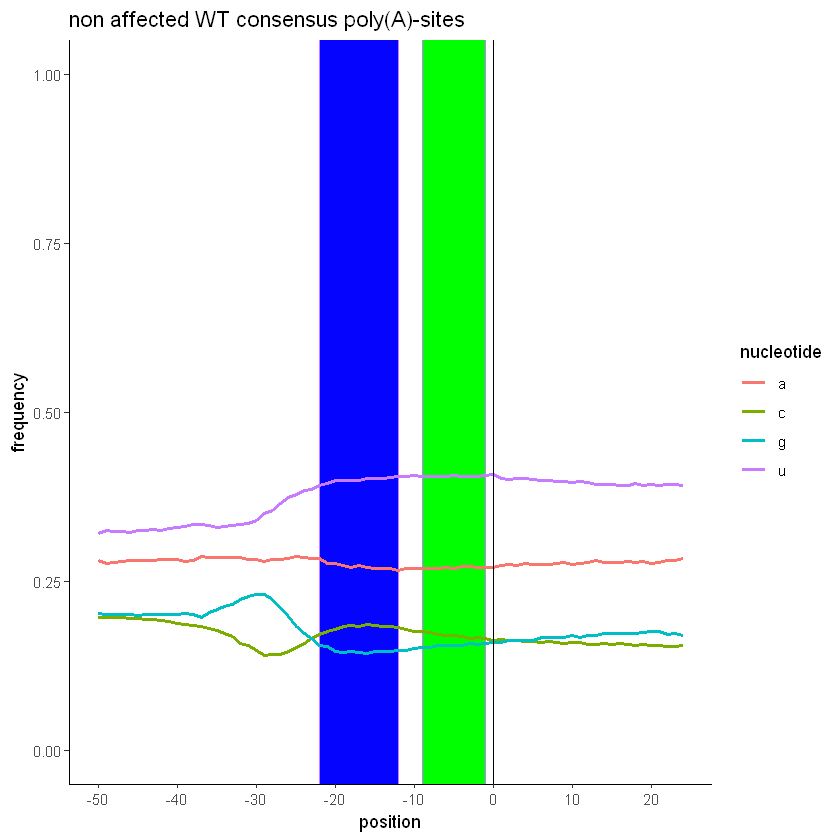

In [56]:
plot_onethird_of_all_introns_light = ggplot(a %>% filter(position < 25), aes(x = position, y = frequency, col = nucleotide)) +
  ggtitle("non affected WT consensus poly(A)-sites") +
  geom_rect( xmin = -22, xmax = -12, ymin = -1, ymax = 2, fill = "blue", alpha = 0.1, show.legend = FALSE) + 
  geom_rect( xmin = -9, xmax = -1, ymin = -1, ymax = 2, alpha = 0.3, fill = "green", show.legend = FALSE) + 
  geom_line(linewidth = 0.9) + 
  geom_vline(xintercept=0)  + 
  scale_x_continuous(breaks = c(-50,-40,-30,-20, -10,0,10,20,30,40,60)) +
  ylim(0,1) + 
  theme_classic()

plot_onethird_of_all_introns_light

## 3.2 Overlaps between DEGs and splicing events

In [57]:
significant_degs_overlap = merge(res_u1c %>% as.data.frame() %>% filter(padj < 0.05), res_u170k %>% as.data.frame() %>% filter(padj < 0.05), by = 0, suffixes = c("_u1c", "_u170k"))
colnames(significant_degs_overlap)[1] = "GeneID"
overlap_degs = nrow(significant_degs_overlap)


overlap_deg_rmats_se  = merge(significant_degs_overlap, overlap_se, by = "GeneID", suffixes = c("_deg", "_rmats")) 
overlap_deg_rmats_ri  = merge(significant_degs_overlap, overlap_ri, by = "GeneID", suffixes = c("_deg", "_rmats"))
overlap_deg_rmats_a5s = merge(significant_degs_overlap, overlap_a5s, by = "GeneID", suffixes = c("_deg", "_rmats")) 
overlap_deg_rmats_a3s = merge(significant_degs_overlap, overlap_a3s, by = "GeneID", suffixes = c("_deg", "_rmats"))
overlap_deg_rmats_mxe = merge(significant_degs_overlap, overlap_mxe, by = "GeneID", suffixes = c("_deg", "_rmats")) 


universe_se  = length(unique(c(significant_degs_overlap$GeneID, overlap_se$GeneID)))
universe_ri  = length(unique(c(significant_degs_overlap$GeneID, overlap_ri$GeneID)))
universe_a5s = length(unique(c(significant_degs_overlap$GeneID, overlap_a5s$GeneID)))
universe_a3s = length(unique(c(significant_degs_overlap$GeneID, overlap_a3s$GeneID)))
universe_mxe = length(unique(c(significant_degs_overlap$GeneID, overlap_mxe$GeneID)))



a = phyper(nrow(overlap_deg_rmats_se)-1,  overlap_degs, universe_se-overlap_degs,  nrow(overlap_se),  lower.tail = F) 
b = phyper(nrow(overlap_deg_rmats_ri)-1,  overlap_degs, universe_ri-overlap_degs,  nrow(overlap_ri),  lower.tail = F) 
c = phyper(nrow(overlap_deg_rmats_a5s)-1, overlap_degs, universe_a5s-overlap_degs, nrow(overlap_a5s), lower.tail = F) 
d = phyper(nrow(overlap_deg_rmats_a3s)-1, overlap_degs, universe_a3s-overlap_degs, nrow(overlap_a3s), lower.tail = F) 
e = phyper(nrow(overlap_deg_rmats_mxe)-1, overlap_degs, universe_mxe-overlap_degs, nrow(overlap_mxe), lower.tail = F) 



print(paste0("p-Value of hypergeometic test for significance of overlap (",nrow(overlap_deg_rmats_se) ,") between DEGs (",overlap_degs, ") and skipped exon events (",nrow(overlap_se) ,") = ", a))
print(paste0("p-Value of hypergeometic test for significance of overlap (",nrow(overlap_deg_rmats_ri),") between DEGs (",overlap_degs, ") and retained intron events (",nrow(overlap_ri) ,") = ", b))
print(paste0("p-Value of hypergeometic test for significance of overlap (",nrow(overlap_deg_rmats_a5s) ,") between DEGs (",overlap_degs, ") and alternative 5'SS events (",nrow(overlap_a5s) ,") = ", c))
print(paste0("p-Value of hypergeometic test for significance of overlap (",nrow(overlap_deg_rmats_a3s) ,") between DEGs (",overlap_degs, ") and alternative 3'SS events (",nrow(overlap_a3s) ,") = ", d))
print(paste0("p-Value of hypergeometic test for significance of overlap (",nrow(overlap_deg_rmats_mxe) ,") between DEGs (",overlap_degs, ") and mutually exclusive exon (",nrow(overlap_mxe) ,") events = ", e))


#now test all Rmats events vs all degs
universe_diff_spliced_deg = length(unique(c(significant_degs_overlap$GeneID, overlap_a3s$GeneID, overlap_a5s$GeneID, overlap_ri$GeneID, overlap_se$GeneID, overlap_mxe$GeneID)))
universe_diff_spliced =  length(unique(c(overlap_a3s$GeneID, overlap_a5s$GeneID, overlap_ri$GeneID, overlap_se$GeneID, overlap_mxe$GeneID)))
overlap_deg_diffpliced = length(intersect(significant_degs_overlap$GeneID, unique(c(overlap_a3s$GeneID, overlap_a5s$GeneID, overlap_ri$GeneID, overlap_se$GeneID, overlap_mxe$GeneID))))


f = phyper(overlap_deg_diffpliced-1, overlap_degs, universe_diff_spliced_deg - overlap_degs, universe_diff_spliced, lower.tail = F)
results_overlap_degs_all_rmats = paste0("The probability that the overlap (",overlap_deg_diffpliced, ") between all differently expressed genes (",overlap_degs,") and all genes with at least one splicing event (",universe_diff_spliced,"), where all possible genes are (",universe_diff_spliced_deg,") is happening by chance is ",f )
print(results_overlap_degs_all_rmats)




[1] "p-Value of hypergeometic test for significance of overlap (159) between DEGs (2374) and skipped exon events (741) = 1"
[1] "p-Value of hypergeometic test for significance of overlap (284) between DEGs (2374) and retained intron events (1313) = 1"
[1] "p-Value of hypergeometic test for significance of overlap (80) between DEGs (2374) and alternative 5'SS events (432) = 1"
[1] "p-Value of hypergeometic test for significance of overlap (60) between DEGs (2374) and alternative 3'SS events (305) = 1"
[1] "p-Value of hypergeometic test for significance of overlap (3) between DEGs (2374) and mutually exclusive exon (20) events = 1"
[1] "The probability that the overlap (295) between all differently expressed genes (2374) and all genes with at least one splicing event (1608), where all possible genes are (3687) is happening by chance is 1"


In [58]:
write.csv(overlap_deg_rmats_a3s %>% filter(log2FoldChange_u170k > 0 & log2FoldChange_u1c > 0), "overlap_a3ss_degs_up.csv")
write.csv(overlap_deg_rmats_a3s %>% filter(log2FoldChange_u170k < 0 & log2FoldChange_u1c < 0), "overlap_a3ss_degs_down.csv")

write.csv(overlap_deg_rmats_a5s %>% filter(log2FoldChange_u170k > 0 & log2FoldChange_u1c > 0), "overlap_a5ss_degs_up.csv") 
write.csv(overlap_deg_rmats_a5s %>% filter(log2FoldChange_u170k < 0 & log2FoldChange_u1c < 0), "overlap_a5ss_degs_down.csv") 

write.csv(overlap_deg_rmats_mxe %>% filter(log2FoldChange_u170k > 0 & log2FoldChange_u1c > 0), "overlap_mxe_degs_up.csv") 
write.csv(overlap_deg_rmats_mxe %>% filter(log2FoldChange_u170k < 0 & log2FoldChange_u1c < 0), "overlap_mxe_degs_down.csv") 

write.csv(overlap_deg_rmats_ri %>% filter(log2FoldChange_u170k > 0 & log2FoldChange_u1c > 0), "overlap_ri_degs_up.csv") 
write.csv(overlap_deg_rmats_ri %>% filter(log2FoldChange_u170k < 0 & log2FoldChange_u1c < 0), "overlap_ri_degs_down.csv") 

write.csv(overlap_deg_rmats_se %>% filter(log2FoldChange_u170k > 0 & log2FoldChange_u1c > 0), "overlap_se_degs_up.csv") 
write.csv(overlap_deg_rmats_se %>% filter(log2FoldChange_u170k < 0 & log2FoldChange_u1c < 0), "overlap_se_degs_down.csv") 



## 3.3 Overlap DEGs and genes encoding mRNA cleavage and polyadenylation factors

In [59]:
pafactors = read.csv("../polyAfactoren.csv", header = F)

In [60]:
rownames(pafactors) = pafactors$V2

a = merge(pafactors, as.data.frame(res_u1c), by = 0, suffixes = c("", "_u1c"))
rownames(a) = a$Row.names
a$Row.names = NULL

a = merge(a, as.data.frame(res_u170k), by = 0, suffixes = c("", "_u170k"))
a$Row.names = NULL

a = a %>% filter(padj < 0.05 & padj_u170k < 0.05)

colnames(a)[1] = "alias"
colnames(a)[2] = "gene"

write.csv(a, "significant_DE_polyA_factors_u1_project.csv", quote = F, row.names = T)


## 3.4 Expression of mRNA cleavage and polyadenylation factors

In [61]:
pafactors = merge(pafactors, res_u170k %>% as.data.frame() %>% select(baseMean), by = 0)

In [62]:
merged_deg = merge(res_u1c %>% as.data.frame() %>% select(log2FoldChange, lfcSE, stat, pvalue, padj), res_u170k %>% as.data.frame() %>% select(log2FoldChange, lfcSE, stat, pvalue, padj), by = 0, all.x = TRUE, suffixes = c("_u1c", "_u170k"))


In [63]:
pafactors = pafactors[,2:4]
colnames(pafactors) = c("name", "Row.names", "baseMean")

In [64]:
a = merge(pafactors, merged_deg, by = "Row.names")

In [65]:
write.csv(a, "expression_all_pa_factors.csv")

## 3.5 Overlap between alternative splicing events and genes encoding mRNA cleavage and polyadenylation factors

In [67]:
a = merge(pafactors %>% select(Row.names, name), as.data.frame(overlap_a3s %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, all.x = TRUE)
a = merge(a, as.data.frame(overlap_a5s %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, all.x = TRUE, suffixes = c("_A3SS","_A5SS"))
a = merge(a, as.data.frame(overlap_mxe %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, all.x = TRUE)
a = merge(a, as.data.frame(overlap_ri %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, suffixes = c("_MXE","_RI"), all.x = TRUE )
a = merge(a, as.data.frame(overlap_se %>% select(GeneID, `FDR_amiR-u1-c`, `FDR_amirR-u1-70k`)), by = 1, all.x = TRUE )

write.csv(a, file = "pa_factors_rmats_overlap.csv")

## 3.6 Find CPA-Signal in Introns

for this we need to run the extract_motifinfo.sh after the nextflow pipeline, to then use the data in R

In [68]:
collapsed_introns_without_pA                = read.table("collapsed_introns_without_pA")            %>% distinct(.keep_all = T)
distal_pA_where_comp_rep_u1c_new            = read.table("distal_pA_where_comp_rep_u1c_new")        %>% distinct(.keep_all = T)
distal_pA_where_comp_rep_u170k_new          = read.table("distal_pA_where_comp_rep_u170k_new")      %>% distinct(.keep_all = T)
non_affected_WT_consensus_pA_sites_new      = read.table("non_affected_WT_consensus_pA_sites_new")  %>% distinct(.keep_all = T)
proximal_pA_comp_rep_u1c_new                = read.table("proximal_pA_comp_rep_u1c_new")            %>% distinct(.keep_all = T)
proximal_pA_comp_rep_u170k_new              = read.table("proximal_pA_comp_rep_u170k_new")          %>% distinct(.keep_all = T)


#number of rows for collapes_introns                    = 121401
#number of rows for distal_pa_where_comp_rep_u1c        = 88
#number of rows for distal_pa_where_comp_rep_u170k      = 266
#number of rows for proximal_pa_where_comp_rep_u1c      = 90
#number of rows for proximal_pa_where_comp_rep_u170k    = 278
#number of rows for non_affected_WT_consensus_pA_sites  = 1576




rownames = c("proximal_pA_comp_rep_u1c", "proximal_pA_comp_rep_u170k", "distal_pA_comp_rep_u1c", "distal_pA_comp_rep_u170k", "non_affected_WT_pA_sites", "introns_without_utilized_pA_site")
total    = c(90, 278, 88, 266, 1576, 121401)
with_pAsignal = c(nrow(proximal_pA_comp_rep_u1c_new), nrow(proximal_pA_comp_rep_u170k_new), nrow(distal_pA_where_comp_rep_u1c_new), nrow(distal_pA_where_comp_rep_u170k_new), nrow(non_affected_WT_consensus_pA_sites_new), nrow(collapsed_introns_without_pA))


df = data.frame(rownames, total, with_pAsignal) %>% mutate(percentage = with_pAsignal/total)
df

rownames,total,with_pAsignal,percentage
<chr>,<dbl>,<int>,<dbl>
proximal_pA_comp_rep_u1c,90,64,0.7111111
proximal_pA_comp_rep_u170k,278,176,0.6330935
distal_pA_comp_rep_u1c,88,54,0.6136364
distal_pA_comp_rep_u170k,266,181,0.6804511
non_affected_WT_pA_sites,1576,1038,0.6586294
introns_without_utilized_pA_site,121401,33194,0.2734244


In [69]:
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22631)

Matrix products: default

locale:
[1] LC_COLLATE=English_Germany.utf8  LC_CTYPE=English_Germany.utf8   
[3] LC_MONETARY=English_Germany.utf8 LC_NUMERIC=C                    
[5] LC_TIME=English_Germany.utf8    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] patchwork_1.2.0             seqTools_1.32.0            
 [3] zlibbioc_1.44.0             VennDiagram_1.7.3          
 [5] futile.logger_1.4.3         reshape2_1.4.4             
 [7] dplyr_1.1.4                 ggrepel_0.9.5              
 [9] ggplot2_3.5.1               DESeq2_1.38.3              
[11] SummarizedExperiment_1.28.0 Biobase_2.58.0             
[13] MatrixGenerics_1.10.0       matrixStats_1.2.0          
[15] GenomicRanges_1.50.2        GenomeInfoDb_1.34.9        
[17] IRanges_2.32.0            